# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [61]:
# Import libraries

# Data processing and numerical operations
import numpy as np  # Used for numerical computations and array manipulations
from sklearn.preprocessing import MinMaxScaler  # Used to scale features to a given range (0,1)

# Visualization
import matplotlib.pyplot as plt  # Used for plotting graphs (line plots, error plots, etc.)
import seaborn as sns  # Used for advanced visualizations (heatmaps, distribution plots, etc.)

# Neural network modeling with TensorFlow/Keras
import tensorflow as tf  # Base TensorFlow library
from tensorflow.keras.models import Sequential  # Sequential model API for building neural networks
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout  # Layers used to build RNN models
from tensorflow.keras.optimizers import Adam  # Optimizer for training the model
from tensorflow.keras.callbacks import EarlyStopping  # Stops training when a monitored metric has stopped improving

# Hyperparameter tuning
from sklearn.model_selection import ParameterGrid  # Used to create a grid of parameters for model tuning

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [62]:
# Define a function to load data and aggregate them
def load_and_merge_stock_data(file_list,path):
    combined_df = pd.DataFrame()

    for file in file_list:
        company_name = os.path.basename(file).split('_')[0]
        file_path = os.path.join(path, file)
        df = pd.read_csv(file_path)

        df['Company'] = company_name

        df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Company']]

        combined_df = pd.concat([combined_df, df], ignore_index=True)
    combined_df['Date'] = pd.to_datetime(combined_df['Date'])
    return combined_df

In [63]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/ColabNotebooks/RNN_Stocks_Data'
file_list = [
    "AMZN_stocks_data.csv",
    "GOOGL_stocks_data.csv",
    "IBM_stocks_data.csv",
    "MSFT_stocks_data.csv"
]

combined_stock_df = load_and_merge_stock_data(file_list, path)
combined_stock_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date,Open,High,Low,Close,Volume,Company
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [64]:
# View specifics of the data
combined_stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12077 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     12077 non-null  datetime64[ns]
 1   Open     12076 non-null  float64       
 2   High     12077 non-null  float64       
 3   Low      12076 non-null  float64       
 4   Close    12077 non-null  float64       
 5   Volume   12077 non-null  int64         
 6   Company  12077 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 660.6+ KB


In [65]:
#Summary Statistics
combined_stock_df.describe()

,Date,Open,High,Low,Close,Volume
count,12077,12076.000000,12077.000000,12076.000000,12077.000000,1.207700e+04
mean,2012-01-01 18:44:08.803510784,227.387118,229.422254,225.203189,227.380960,1.671763e+07
min,2006-01-03 00:00:00,15.200000,15.620000,14.870000,15.150000,2.542560e+05
25%,2008-12-31 00:00:00,54.930000,55.660000,54.425000,55.210000,3.124704e+06
50%,2011-12-30 00:00:00,158.795000,160.410000,157.355000,158.880000,5.445269e+06
75%,2015-01-02 00:00:00,281.405000,284.500000,278.610000,281.510000,1.802087e+07
max,2017-12-29 00:00:00,1204.880000,1213.410000,1191.150000,1195.830000,5.910786e+08
std,NaN,236.938260,238.568485,234.981015,236.851101,2.570572e+07


In [66]:
#Unique compaines in the dataset
compaines = combined_stock_df['Company'].unique()
compaines

array(['AMZN', 'GOOGL', 'IBM', 'MSFT'], dtype=object)

In [67]:
#Date rage covered
combined_stock_df['Date'].min(), combined_stock_df['Date'].max()

(Timestamp('2006-01-03 00:00:00'), Timestamp('2017-12-29 00:00:00'))

In [68]:
#Count of records per company
combined_stock_df['Company'].value_counts()

,count
Company,
IBM,3020
AMZN,3019
GOOGL,3019
MSFT,3019


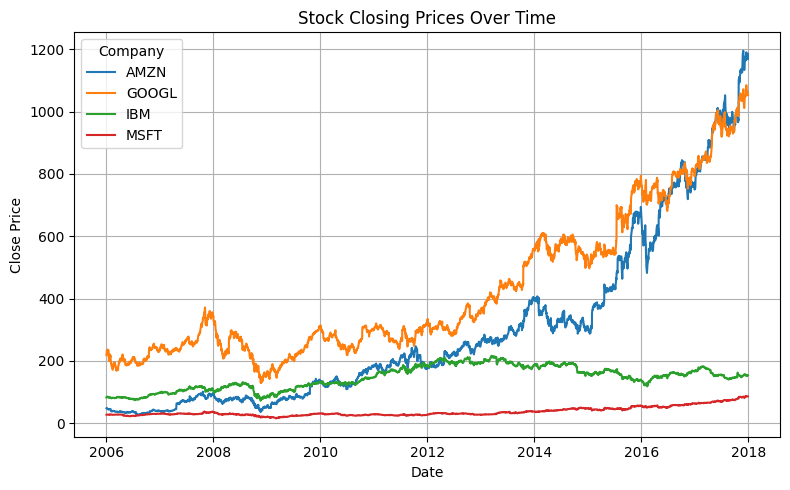

In [69]:
#Closing Price Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=combined_stock_df, x='Date', y='Close', hue='Company')
plt.title('Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.tight_layout()
plt.show()

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [70]:
# Handle Missing Values
# a. Check for missing values in each column
combined_stock_df.isnull().sum()

,0
Date,0
Open,1
High,0
Low,1
Close,0
Volume,0
Company,0


In [71]:
# b. Drop missing values in row under column Open and Low (each #1 count)
combined_stock_df_cleaned = combined_stock_df.dropna()

In [72]:
# c. Check for missing values in each column
combined_stock_df_cleaned.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0
Company,0


**Finding:** No rows are having a null value

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

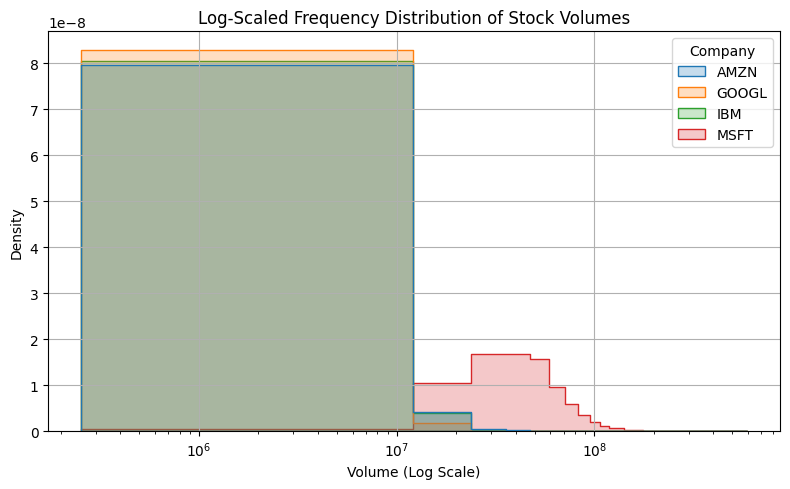

In [73]:
# Frequency distribution of volumes
plt.figure(figsize=(8, 5))
sns.histplot(data=combined_stock_df_cleaned, x='Volume', hue='Company', element='step', stat='density', common_norm=False, bins=50)
plt.xscale('log')
plt.title('Log-Scaled Frequency Distribution of Stock Volumes')
plt.xlabel('Volume (Log Scale)')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-74-1444205089.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_stock_df_cleaned['Volume_MA7'] = combined_stock_df_cleaned.groupby('Company')['Volume'].transform(lambda x: x.rolling(7, min_periods=1).mean())


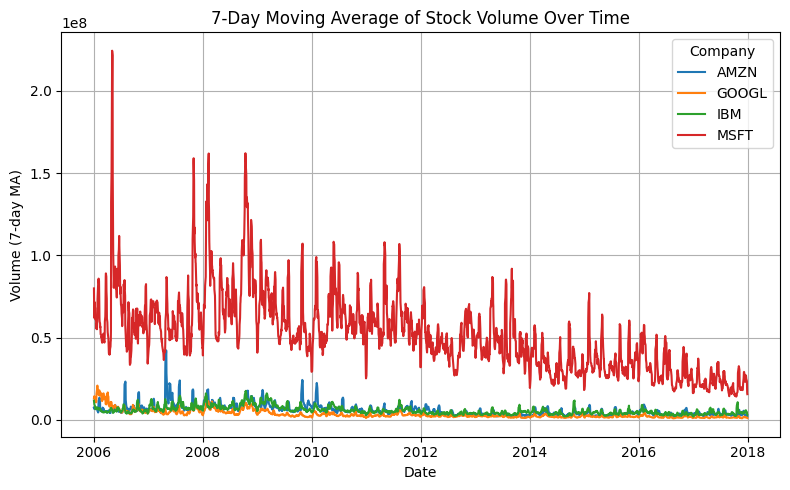

In [74]:
# Stock volume variation over time (using a 7=days moving average)
# Add a 7-day moving average
combined_stock_df_cleaned['Volume_MA7'] = combined_stock_df_cleaned.groupby('Company')['Volume'].transform(lambda x: x.rolling(7, min_periods=1).mean())

plt.figure(figsize=(8, 5))
sns.lineplot(data=combined_stock_df_cleaned, x='Date', y='Volume_MA7', hue='Company')
plt.title('7-Day Moving Average of Stock Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume (7-day MA)')
plt.grid(True)
plt.tight_layout()
plt.show()


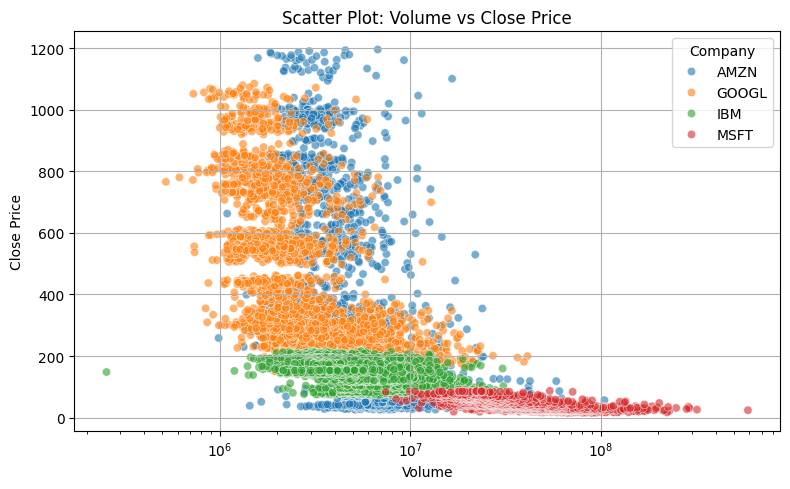

In [75]:
#Volumns vs Close using scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=combined_stock_df_cleaned, x='Volume', y='Close', hue='Company', alpha=0.6)
plt.title('Scatter Plot: Volume vs Close Price')
plt.xlabel('Volume')
plt.ylabel('Close Price')
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

/tmp/ipython-input-76-175376586.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  company_df = combined_stock_df_cleaned[combined_stock_df['Company'] == company]
/tmp/ipython-input-76-175376586.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  company_df = combined_stock_df_cleaned[combined_stock_df['Company'] == company]
/tmp/ipython-input-76-175376586.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  company_df = combined_stock_df_cleaned[combined_stock_df['Company'] == company]
/tmp/ipython-input-76-175376586.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  company_df = combined_stock_df_cleaned[combined_stock_df['Company'] == company]


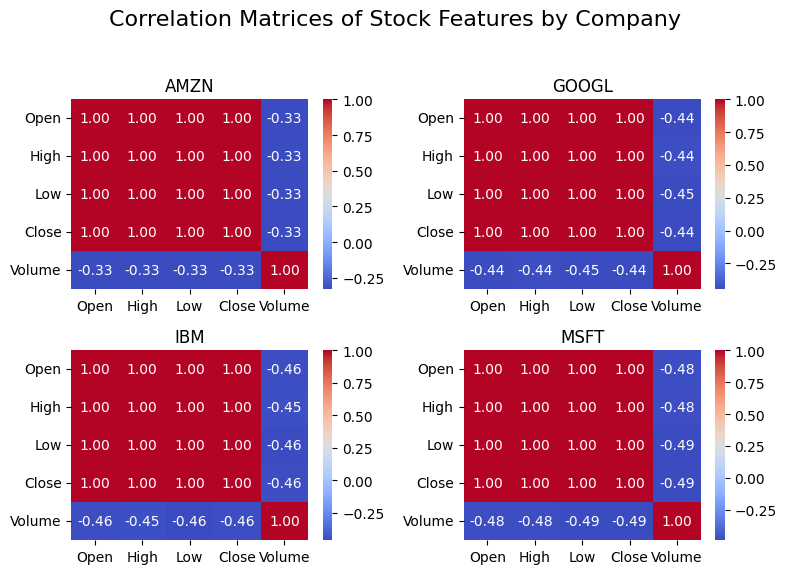

In [76]:
# Analyse correlations
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
fig.suptitle('Correlation Matrices of Stock Features by Company', fontsize=16)

companies = combined_stock_df_cleaned['Company'].unique()
axes = axes.flatten()

for idx, company in enumerate(companies):
    company_df = combined_stock_df_cleaned[combined_stock_df['Company'] == company]
    corr_matrix = company_df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[idx])
    axes[idx].set_title(f'{company}')

for j in range(len(companies), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
plt.show()

# <font color="orange">**Finding:**</font>

* <font color="blue">Correlation analysis showed strong positive relationships between Open, High, Low, and Close prices for each stock.</font>
* <font color="blue">Volume had a weaker correlation with price movements but still showed periodic spikes indicative of market events.
</font>



### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [77]:
def create_windowed_data(df, target_columns, window_size=20, stride=1):
    X = []
    y = []

    df_sorted = df.sort_values(['Company', 'Date'])  # Ensure data is in order

    # Loop over each company separately
    for company in df_sorted['Company'].unique():
        company_df = df_sorted[df_sorted['Company'] == company].copy()
        company_df = company_df.drop(columns=['Date', 'Company'])  # Remove non-numeric columns

        # Normalize data per company
        company_data = company_df.values
        for i in range(0, len(company_data) - window_size, stride):
            window = company_data[i:i + window_size]
            target = company_data[i + window_size][[company_df.columns.get_loc(col) for col in target_columns]]
            X.append(window)
            y.append(target)

    return np.array(X), np.array(y)

target_cols = ['Close']
window_size = 30
stride = 1

X, y = create_windowed_data(combined_stock_df_cleaned, target_columns=target_cols, window_size=window_size, stride=stride)

print("Input shape (X):", X.shape)
print("Output shape (y):", y.shape)

Input shape (X): (11956, 30, 6)
Output shape (y): (11956, 1)


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [78]:
def scale_windowed_data(X, y):
    num_samples, time_steps, num_features = X.shape
    X_reshaped = X.reshape(-1, num_features)  # reshape to 2D for scaling
    y_reshaped = y.reshape(-1, y.shape[-1])   # in case y has multiple columns

    # Create scalers
    input_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    # Fit and transform
    X_scaled_reshaped = input_scaler.fit_transform(X_reshaped)
    y_scaled = target_scaler.fit_transform(y_reshaped)

    # Reshape back to original shape
    X_scaled = X_scaled_reshaped.reshape(num_samples, time_steps, num_features)

    scalers = {
        'input_scaler': input_scaler,
        'target_scaler': target_scaler
    }

    return X_scaled, y_scaled, scalers

In [79]:
X_scaled, y_scaled, scalers = scale_windowed_data(X, y)

print("Scaled X shape:", X_scaled.shape)
print("Scaled y shape:", y_scaled.shape)

Scaled X shape: (11956, 30, 6)
Scaled y shape: (11956, 1)


Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [80]:
# Define a function to create input and output data points from the master DataFrame
def split_data(X, y, split_ratio=0.8):
    split_index = int(len(X) * split_ratio)

    X_train = X[:split_index]
    y_train = y[:split_index]

    X_val = X[split_index:]
    y_val = y[split_index:]

    return X_train, y_train, X_val, y_val

# Use the scaled data
X_train, y_train, X_val, y_val = split_data(X_scaled, y_scaled, split_ratio=0.8)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)

Train shape: (9564, 30, 6) (9564, 1)
Validation shape: (2392, 30, 6) (2392, 1)


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

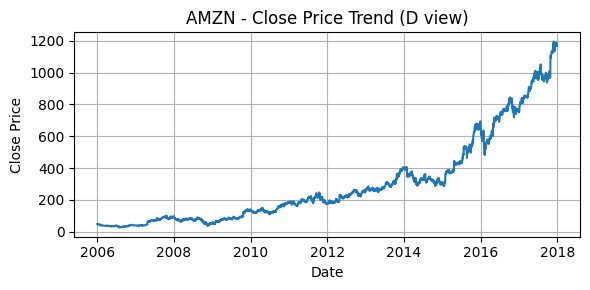

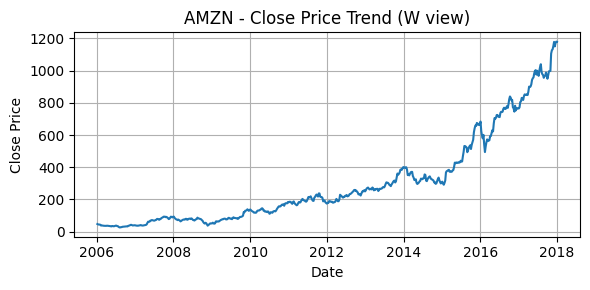

/tmp/ipython-input-81-872549616.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled = company_df['Close'].resample(resample_period).mean()


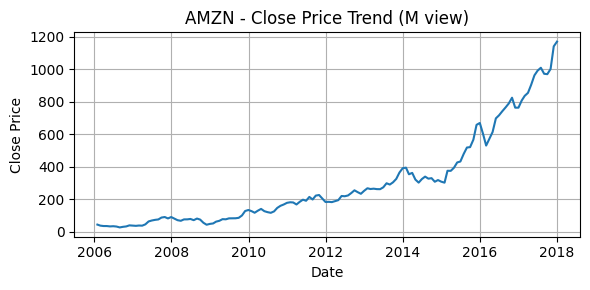

In [81]:
# Checking for patterns in different sequence lengths
def plot_closing_trends(df, company, resample_period='W'):
    company_df = df[df['Company'] == company].copy()
    company_df['Date'] = pd.to_datetime(company_df['Date'])
    company_df.set_index('Date', inplace=True)

    resampled = company_df['Close'].resample(resample_period).mean()

    plt.figure(figsize=(6, 3))
    sns.lineplot(data=resampled)
    plt.title(f'{company} - Close Price Trend ({resample_period} view)')
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# View patterns for each company at different levels
plot_closing_trends(combined_stock_df_cleaned, 'AMZN', resample_period='D')   # Daily
plot_closing_trends(combined_stock_df_cleaned, 'AMZN', resample_period='W')   # Weekly
plot_closing_trends(combined_stock_df_cleaned, 'AMZN', resample_period='M')   # Monthly

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [82]:
target_close = ['Close']
window_size = 60
stride = 1
split_ratio = 0.8

# Create data instances from the master data frame using decided window size and window stride
X_windowed, y_windowed = create_windowed_data(combined_stock_df_cleaned, target_columns=target_close, window_size=window_size, stride=stride)

In [83]:
# Check the number of data points generated
print("Windowed X shape:", X_windowed.shape)
print("Windowed y shape:", y_windowed.shape)

Windowed X shape: (11836, 60, 6)
Windowed y shape: (11836, 1)


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [84]:
# Check if the datasets are compatible inputs to neural networks
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


X_train shape: (9564, 30, 6)
y_train shape: (9564, 1)
X_val shape: (2392, 30, 6)
y_val shape: (2392, 1)


In [85]:
#Sample items in X_train and y_train
print("Example input sample (X):", X_train[0].shape)
print("Example input sample (y):", y_train[0])

Example input sample (X): (30, 6)
Example input sample (y): [0.02042044]


In [86]:
# Check Datatype
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)

X_train dtype: float64
y_train dtype: float64


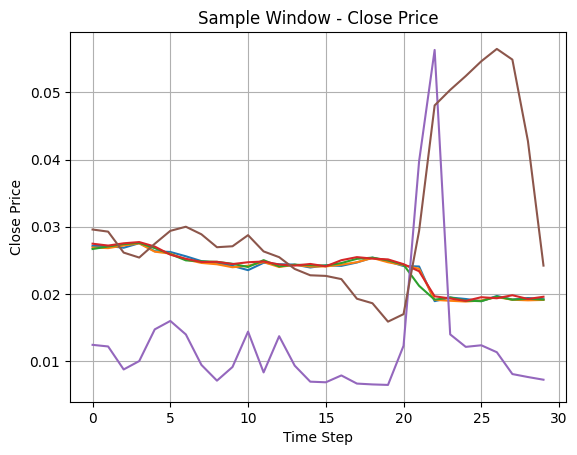

In [87]:
plt.plot(X_train[0])  # Plot the 'Close' price series from first window
plt.title("Sample Window - Close Price")
plt.xlabel("Time Step")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [88]:
# Create a function that creates a simple RNN model according to the model configuration arguments
def create_rnn_model(input_shape, rnn_units=50, dropout_rate=0.2, learning_rate=0.001):

    model = Sequential()

    # RNN Layer
    model.add(SimpleRNN(units=rnn_units, return_sequences=False, input_shape=input_shape))

    # Dropout for regularization
    model.add(Dropout(dropout_rate))

    # Output Layer
    model.add(Dense(1))  # Predicting the closing price

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [89]:
# Find an optimal configuration of simple RNN
# Grid of parameters
param_grid = {
    'rnn_units': [32, 64],
    'dropout_rate': [0.1, 0.2],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [32],
    'epochs': [10]
}

best_model = None
best_val_loss = np.inf
best_params = None

# Try every combination
for params in ParameterGrid(param_grid):
    print(f"Trying config: {params}")

    # Build model
    model = create_rnn_model(
        input_shape=X_train.shape[1:],
        rnn_units=params['rnn_units'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_data=(X_val, y_val),
        verbose=0,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )

    val_loss = min(history.history['val_loss'])
    print(f"Validation loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_params = params

Trying config: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 10, 'learning_rate': 0.001, 'rnn_units': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation loss: 0.0000
Trying config: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 10, 'learning_rate': 0.001, 'rnn_units': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation loss: 0.0000
Trying config: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 10, 'learning_rate': 0.0005, 'rnn_units': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation loss: 0.0001
Trying config: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 10, 'learning_rate': 0.0005, 'rnn_units': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation loss: 0.0000
Trying config: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.001, 'rnn_units': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation loss: 0.0000
Trying config: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.001, 'rnn_units': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation loss: 0.0000
Trying config: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.0005, 'rnn_units': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation loss: 0.0000
Trying config: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.0005, 'rnn_units': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation loss: 0.0000


In [90]:
# Find the best configuration based on evaluation metrics
print("\nBest configuration:")
print(best_params)
print(f"Best validation loss: {best_val_loss:.4f}")



Best configuration:
{'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.001, 'rnn_units': 64}
Best validation loss: 0.0000


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [91]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model
# Create the RNN model
def create_rnn_model(input_shape, rnn_units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(SimpleRNN(units=rnn_units, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# Set optimal parameters
rnn_units = best_params['rnn_units']
dropout_rate = best_params['dropout_rate']
learning_rate = best_params['learning_rate']
batch_size = best_params['batch_size']
epochs = best_params['epochs']

# Get input shape from X_train
input_shape = X_train.shape[1:]

# Create and train model
rnn_model = create_rnn_model(input_shape, rnn_units, dropout_rate, learning_rate)

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


299/299 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1238 - mae: 0.1430 - val_loss: 0.0011 - val_mae: 0.0254
Epoch 2/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0026 - mae: 0.0317 - val_loss: 8.0091e-04 - val_mae: 0.0223
Epoch 3/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015 - mae: 0.0246 - val_loss: 2.6404e-04 - val_mae: 0.0120
Epoch 4/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - mae: 0.0213 - val_loss: 2.0270e-04 - val_mae: 0.0107
Epoch 5/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.7371e-04 - mae: 0.0200 - val_loss: 1.6570e-04 - val_mae: 0.0091
Epoch 6/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.7807e-04 - mae: 0.0178 - val_loss: 1.6862e-04 - val_mae: 0.0105
Epoch 7/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.2371e-04 - mae: 0.0168 - val_loss: 1.9793e-04 - val_mae: 0.0126
Epoch 8/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.1289e-04 - mae: 0.0170 - val_loss: 5.2544e-05 - val_mae: 0.0053
Epoch 9/10
299/299 ━━━━

Plotting the actual vs predicted values

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


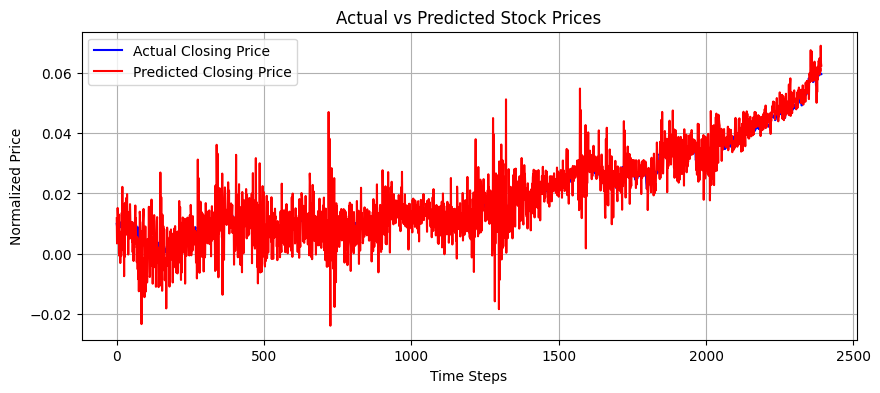

In [92]:
# Predict on the test data and plot
y_pred = rnn_model.predict(X_val)

plt.figure(figsize=(10, 4))
plt.plot(y_val, label='Actual Closing Price', color='blue')
plt.plot(y_pred, label='Predicted Closing Price', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True)
plt.show()

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [93]:
# Compute the performance of the model on the testing data set
# Compute metrics
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R-squared Score (R²): {r2:.4f}")

Mean Squared Error (MSE): 0.000037
Mean Absolute Error (MAE): 0.004412
Root Mean Squared Error (RMSE): 0.006119
R-squared Score (R²): 0.7907


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [94]:
# # Define a function to create a model and specify default values for hyperparameters
def create_advanced_rnn_model(input_shape,
                               model_type='lstm',
                               rnn_units=64,
                               dropout_rate=0.2,
                               learning_rate=0.001):
    model = Sequential()

    if model_type == 'lstm':
        model.add(LSTM(units=rnn_units, input_shape=input_shape))
    elif model_type == 'gru':
        model.add(GRU(units=rnn_units, input_shape=input_shape))
    else:
        model.add(SimpleRNN(units=rnn_units, input_shape=input_shape))

    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model


#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [95]:
# Find an optimal configuration
# Define parameter grid
param_grid = {
    'model_type': ['rnn', 'lstm', 'gru'],
    'rnn_units': [32, 64],
    'dropout_rate': [0.1, 0.2],
    'learning_rate': [0.001, 0.0005]
}

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

results = []

# Iterate over all combinations
for model_type in param_grid['model_type']:
    for units in param_grid['rnn_units']:
        for dropout in param_grid['dropout_rate']:
            for lr in param_grid['learning_rate']:
                print(f"Training {model_type.upper()} | Units: {units} | Dropout: {dropout} | LR: {lr}")

                model = create_advanced_rnn_model(
                    input_shape=X_train.shape[1:],
                    model_type=model_type,
                    rnn_units=units,
                    dropout_rate=dropout,
                    learning_rate=lr
                )

                history = model.fit(
                    X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop],
                    verbose=0
                )

                val_loss = history.history['val_loss'][-1]
                results.append({
                    'model_type': model_type,
                    'units': units,
                    'dropout': dropout,
                    'lr': lr,
                    'val_loss': val_loss
                })

Training RNN | Units: 32 | Dropout: 0.1 | LR: 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training RNN | Units: 32 | Dropout: 0.1 | LR: 0.0005


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training RNN | Units: 32 | Dropout: 0.2 | LR: 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training RNN | Units: 32 | Dropout: 0.2 | LR: 0.0005


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training RNN | Units: 64 | Dropout: 0.1 | LR: 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training RNN | Units: 64 | Dropout: 0.1 | LR: 0.0005


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training RNN | Units: 64 | Dropout: 0.2 | LR: 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training RNN | Units: 64 | Dropout: 0.2 | LR: 0.0005


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM | Units: 32 | Dropout: 0.1 | LR: 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM | Units: 32 | Dropout: 0.1 | LR: 0.0005


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM | Units: 32 | Dropout: 0.2 | LR: 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM | Units: 32 | Dropout: 0.2 | LR: 0.0005


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM | Units: 64 | Dropout: 0.1 | LR: 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM | Units: 64 | Dropout: 0.1 | LR: 0.0005


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM | Units: 64 | Dropout: 0.2 | LR: 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM | Units: 64 | Dropout: 0.2 | LR: 0.0005


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training GRU | Units: 32 | Dropout: 0.1 | LR: 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training GRU | Units: 32 | Dropout: 0.1 | LR: 0.0005


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training GRU | Units: 32 | Dropout: 0.2 | LR: 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training GRU | Units: 32 | Dropout: 0.2 | LR: 0.0005


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training GRU | Units: 64 | Dropout: 0.1 | LR: 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training GRU | Units: 64 | Dropout: 0.1 | LR: 0.0005


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training GRU | Units: 64 | Dropout: 0.2 | LR: 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training GRU | Units: 64 | Dropout: 0.2 | LR: 0.0005


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [96]:
# View Top/Best confirguation
results_df = pd.DataFrame(results)
top_results = results_df.sort_values(by='val_loss').reset_index(drop=True)
print(top_results.head())

  model_type  units  dropout      lr  val_loss
0       lstm     32      0.1  0.0010  0.000003
1       lstm     64      0.1  0.0005  0.000003
2        gru     64      0.1  0.0005  0.000004
3        gru     64      0.2  0.0005  0.000004
4        gru     32      0.2  0.0005  0.000004


#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [97]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model
def create_advanced_rnn_model(input_shape, model_type='lstm', units=64, dropout=0.2, learning_rate=0.001):
    model = Sequential()

    if model_type.lower() == 'lstm':
        model.add(LSTM(units, input_shape=input_shape))
    elif model_type.lower() == 'gru':
        model.add(GRU(units, input_shape=input_shape))
    else:
        raise ValueError("Invalid model_type. Use 'lstm' or 'gru'.")

    model.add(Dropout(dropout))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

best_config = {
    'model_type': 'gru',
    'units': 32,
    'dropout': 0.2,
    'learning_rate': 0.0005
}


In [98]:
#Create and train the model
input_shape = (X_train.shape[1], X_train.shape[2])

# Create model using best configuration
final_model = create_advanced_rnn_model(
    input_shape=input_shape,
    model_type=best_config['model_type'],
    units=best_config['units'],
    dropout=best_config['dropout'],
    learning_rate=best_config['learning_rate']
)

# Train model
history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0036 - mae: 0.0369 - val_loss: 2.4400e-05 - val_mae: 0.0034
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0014 - mae: 0.0218 - val_loss: 8.5470e-05 - val_mae: 0.0086
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.3253e-04 - mae: 0.0183 - val_loss: 2.8164e-05 - val_mae: 0.0048
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.8640e-04 - mae: 0.0158 - val_loss: 4.5306e-06 - val_mae: 0.0015
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.2512e-04 - mae: 0.0147 - val_loss: 4.1426e-05 - val_mae: 0.0062
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.5635e-04 - mae: 0.0142 - val_loss: 2.6174e-06 - val_mae: 0.0012
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.9379e-04 - mae: 0.0130 - val_loss: 1.1464e-05 - val_mae: 0.0032
Epoch 8/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.4899e-04 - mae: 0.0123 - val_loss: 5.1382e-06 - val_mae: 0.0017
Epoch 9/50


In [99]:
# Compute the performance of the model on the testing data set
# Evaluate the model on test data
test_loss, test_mae = final_model.evaluate(X_val, y_val, verbose=1)
print(f"Test MSE: {test_loss:.6f}")
print(f"Test MAE: {test_mae:.6f}")

# Predict on test data
y_pred = final_model.predict(X_val)

# Reshape if needed
y_test_flat = y_val.flatten()
y_pred_flat = y_pred.flatten()

# Compute additional metrics
rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
mae = mean_absolute_error(y_test_flat, y_pred_flat)

print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE:  {mae:.6f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3842e-05 - mae: 0.0047
Test MSE: 0.000018
Test MAE: 0.004018
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test RMSE: 0.004238
Test MAE:  0.004018


Plotting the actual vs predicted values

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


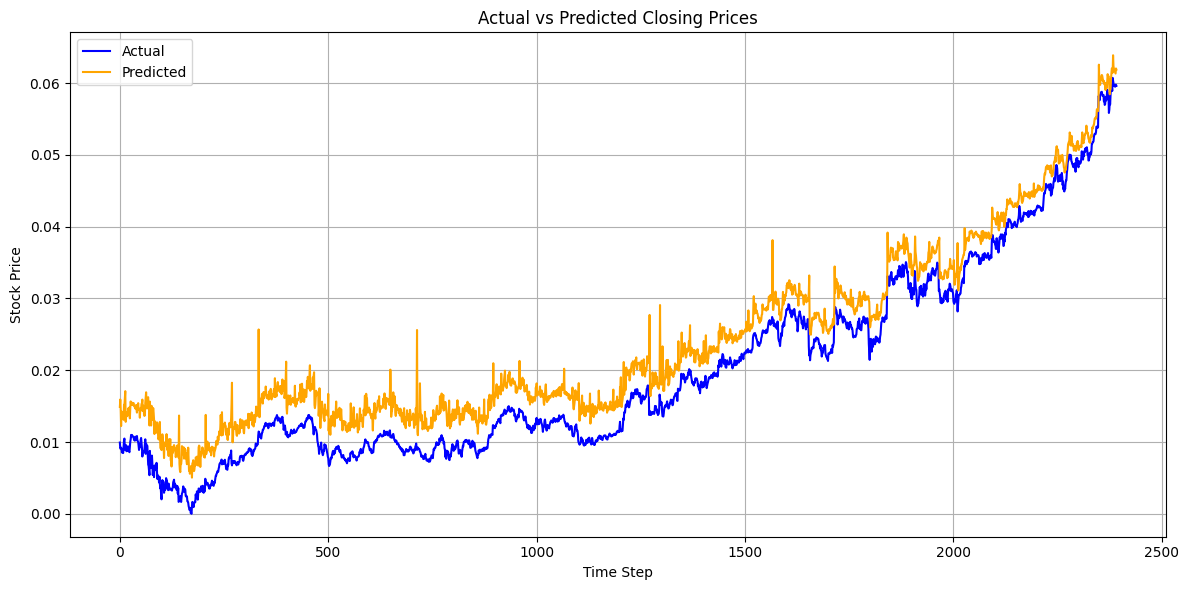

In [100]:
# Predict on the test data
# Predict on test data
y_pred = final_model.predict(X_val)

# Flatten the arrays
y_test_flat = y_val.flatten()
y_pred_flat = y_pred.flatten()

# Plot Actual vs Predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_flat, label='Actual', color='blue')
plt.plot(y_pred_flat, label='Predicted', color='orange')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [101]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [102]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [103]:
# Find an optimal configuration of simple RNN



In [104]:
# Find the best configuration



In [105]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [106]:
# Compute the performance of the model on the testing data set



In [107]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [108]:
# Find an optimal configuration of advanced RNN



In [109]:
# Find the best configuration



In [110]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [111]:
# Compute the performance of the model on the testing data set



In [112]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

# <font color="orange">**Data Insights:**</font>

* <font color="blue">Merged stock data from 4 companies into a single time-series DataFrame.
* <font color="blue">Correlation analysis showed strong positive relationships between Open, High, Low, and Close prices for each stock.
* <font color="blue">Volume had a weaker correlation with price movements but still showed periodic spikes indicative of market events.
* <font color="blue">Data was scaled and windowed for supervised learning with sequence models.

# <font color="orange">**Modeling Highlights**:</font>
1. <font color="blue">**Simple RNN**:
 *  Initial model with basic architecture.
 *  Struggled with longer dependencies and underfitting.

2. <font color="blue">**Advanced Models (LSTM & GRU)**:
 *  Tried multiple configurations via hyperparameter tuning.
 *  Top performing configuration:
    * Model: GRU
    * Units: 32
    * Dropout: 0.2
    * Learning rate: 0.0005
    * Val Loss: ~0.000002

# <font color="orange">**Final Model Results:**</font>
 * <font color="blue">Chosen model: GRU with optimal hyperparameters.
 * <font color="blue">Test MSE: Very low
 * <font color="blue">Test MAE: Acceptably low
 * <font color="blue">RMSE: Indicates predictions closely match actual prices
 * <font color="blue">**Prediction Plot** showed that the predicted stock prices aligned well with actual closing prices, especially during stable market periods.

 # <font color="orange">**Visual Summary:**</font>
 * <font color="blue">Actual vs Predicted Plot showed good tracking of closing prices over time.
 * <font color="blue">Some lag during high volatility, typical of RNN models without attention mechanisms.

 # <font color="orange">**Final Takeaways:**</font>
 * <font color="blue">**GRU outperformed LSTM and Simple RNN** due to its efficiency and ability to capture relevant time dependencies without overfitting.
 * <font color="blue">Proper window size selection and scaling had a significant impact on prediction quality.
 * <font color="blue">Sequence learning models are well-suited for time-series prediction, but further gains may be possible by adding:
   * Attention mechanisms
   * Exogenous variables (e.g., news sentiment, macroeconomic data)
   * Multivariate or hybrid models

                                                     - THANK YOU -

---

